# Initialize Notebook

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as pe
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import tensorflow as tf
import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd
import pickle as pkl
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from scipy.spatial.distance import cdist

%jsroot on
# %matplotlib qt
%matplotlib inline

In [30]:
sys.path.append('../python/')
from filterMethods import *
from timeMethods import *
from gridMethods import *
from trackReconstructionMethods import *
from vertexReconstructionMethods import *
from hitAccuracyMethods import *
from statisticsMethods import *
from importMethods import *
from constants import *
from plotMethods import *
import plotParameters

In [31]:
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

# Load Data

In [32]:
useHistograms = True

checkFiles = False

saveDf_hits                = True
saveDf_primary             = True
saveDfOnlyIfNoFile_hits    = True
saveDfOnlyIfNoFile_primary = True
saveDf_hits_basePath       = 'data/MLdata/MLdata_DF_hits'
saveDf_primary_basePath    = 'data/MLdata/MLdata_DF_primary'

saveGrid_hits                = True
saveGrid_primary             = True
saveGridOnlyIfNoFile_hits    = True
saveGridOnlyIfNoFile_primary = True
saveGrid_hits_basePath       = 'data/MLdata/MLdata_grid_hits'
saveGrid_primary_basePath    = 'data/MLdata/MLdata_grid_primary'

saveModel          = True
saveModel_basePath = 'data/MLmodels/MLmodel'

In [33]:
histDir = '/photoSensor_hits_histograms'
treeName = 'photoSensor_hits;1'
minInitialPositions = 20
minWalls = 2

fileNumbers = [i for i in range(1138)]
fileNames = ['../runs/MLtrainData/multievent_{}.root'.format(i) for i in tqdm.tqdm(fileNumbers)]

if (saveDf_hits or saveDf_primary) and checkFiles:
    sizes = [get_histogram_sizes(fileName, histDir) for fileName in tqdm.tqdm(fileNames)]
    if len(np.unique(np.array(sizes).reshape(-1, 2))) > 1:
        raise Exception('Different sizes:', np.unique(sizes))
    nHits = [get_histogram_nHits_total(fileName, histDir) for fileName in tqdm.tqdm(fileNames)]
    fileNumbers = [fileNumber for fileNumber, nHit in zip(fileNumbers, nHits) if nHit > minInitialPositions]
    fileNames   = [fileName   for fileName  , nHit in zip(fileNames  , nHits) if nHit > minInitialPositions]

print('len(fileNames):', len(fileNames))

100%|██████████| 1138/1138 [00:00<00:00, 3416691.45it/s]

len(fileNames): 1138


In [34]:
dfPaths_hits    = [f"{saveDf_hits_basePath}_{i}.parquet"    for i in fileNumbers]
dfPaths_primary = [f"{saveDf_primary_basePath}_{i}.parquet" for i in fileNumbers]

In [35]:
treeName = 'photoSensor_hits;1'

def rToTheta(r):
    return r/(CM_PER_RAD*MM_PER_CM)

if saveDf_hits:
    for i, (fileName, dfPath_hits) in tqdm.tqdm(enumerate(zip(fileNames, dfPaths_hits)), total=len(fileNames)):
        if saveDfOnlyIfNoFile_hits and os.path.exists(dfPath_hits):
            continue
        df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'sensor_wall', 'relativePosition_binned', 'relativePosition_nBin'])
        if useHistograms:
            photosensor_IDs, photosensor_directions, photosensor_positions, photosensor_walls, position_relative_binned, position_relative_nBin = get_histogram_hits_tuple(fileName, histDir, True)
            df_hits['sensor_name'            ] = photosensor_IDs
            df_hits['sensor_direction'       ] = photosensor_directions
            df_hits['sensor_position'        ] = photosensor_positions
            df_hits['sensor_wall'            ] = photosensor_walls
            df_hits['relativePosition_binned'] = position_relative_binned
            df_hits['relativePosition_nBin'  ] = position_relative_nBin
            # print('df_hits:', df_hits)
        else:
            df_hits['sensor_name'            ] = get_photosensor_hits_photosensor_ID          (fileName, treeName, histDir, verbose=False)
            df_hits['sensor_direction'       ] = get_photosensor_hits_photosensor_direction   (fileName, treeName, histDir, verbose=False)
            df_hits['sensor_position'        ] = get_photosensor_hits_photosensor_position    (fileName, treeName, histDir, verbose=False)
            df_hits['sensor_wall'            ] = get_photosensor_hits_photosensor_wall        (fileName, treeName, histDir, verbose=False)
            # df_hits['relativePosition'       ] = get_photosensor_hits_position_relative       (fileName, treeName, histDir, verbose=False)
            df_hits['relativePosition_binned'] = get_photosensor_hits_position_relative_binned(fileName, treeName, histDir, verbose=False)
            df_hits['relativePosition_nBin'  ] = get_photosensor_hits_position_relative_nBin  (fileName, treeName, histDir, verbose=False)
            df_hits['initialPosition'        ] = get_photosensor_hits_position_initial        (fileName, treeName,          verbose=False)

        df_hits = make_r                            (df_hits)
        df_hits = filter_r                          (df_hits, Y_LIM)
        df_hits = make_theta                        (df_hits, rToTheta)
        df_hits = make_phi                          (df_hits)
        df_hits = make_reconstructedVector_direction(df_hits)
        if 'initialPosition' in df_hits.columns:
            df_hits = make_relativeVector(df_hits)
    
        df_hits.to_parquet(dfPath_hits, compression='snappy')

100%|██████████| 1138/1138 [00:00<00:00, 363804.72it/s]


In [36]:
treeName = 'primary;1'

if saveDf_primary:
    for fileName, dfPath_primary in tqdm.tqdm(zip(fileNames, dfPaths_primary), total=len(fileNames)):
        if saveDfOnlyIfNoFile_primary and os.path.exists(dfPath_primary):
            continue
        df_primary = pd.DataFrame(columns=['position', 'pdg'])
        df_primary['position' ] = get_primary_position(fileName, treeName)
        df_primary['pdg'      ] = get_primary_pdg     (fileName, treeName)
        df_primary = df_primary[df_primary['pdg'] == 13] # muon
        df_primary = df_primary[df_primary['position'].apply(lambda x:
            x[0] > -DETECTOR_SIZE_MM[0]/2 and x[0] < DETECTOR_SIZE_MM[0]/2 and
            x[1] > -DETECTOR_SIZE_MM[1]/2 and x[1] < DETECTOR_SIZE_MM[1]/2 and
            x[2] > -DETECTOR_SIZE_MM[2]/2 and x[2] < DETECTOR_SIZE_MM[2]/2
        )]

        df_primary.to_parquet(dfPath_primary, compression='snappy')

100%|██████████| 1138/1138 [00:00<00:00, 154429.85it/s]


# Plotting Methods

In [37]:
color_oranges = cm.Blues_r  ([0.5,0.6,0.9])
color_blues   = cm.Oranges_r([0.5,0.6,0.9])
blue_1 = "#B6CEC7"
blue_2 = "#92C1A5"
blue_3 = "#889D8E"
red_1  = "#C16464"
red_2  = "#B64D4D"
red_3  = "#FBE6E5"
twilight = cm.twilight(np.linspace(0,1,40))

# Make or Load Grid

In [38]:
gridSize_input  = (20, 20, 20)
gridSize_output = (20, 20, 20)
makeErrors      = False
save            = False
savePlots       = False
load            = False
useWalls        = False

In [39]:
gridPaths_hits    = [f"{saveGrid_hits_basePath}_{i}_{gridSize_input[0]}x{gridSize_input[1]}x{gridSize_input[2]}_{'withWalls' if useWalls else 'noWalls'}_{'withErrors' if makeErrors else 'noErrors'}.npy" for i in fileNumbers]
gridPaths_primary = [f"{saveGrid_primary_basePath}_{i}_{gridSize_output[0]}x{gridSize_output[1]}x{gridSize_output[2]}.npy"                                                                                 for i in fileNumbers]

# Data

In [40]:
if saveGrid_hits:
    for i, dfPath_hits in tqdm.tqdm(enumerate(dfPaths_hits), total=len(dfPaths_hits)):
        if saveGridOnlyIfNoFile_hits and os.path.exists(gridPaths_hits[i]):
            continue

        df_hits = pd.read_parquet(dfPath_hits)

        x, grid_ind, grid_pos = make_voxelGrid(
            df_hits,
            shape=gridSize_input,
            detectorDimensions=DETECTOR_SIZE_MM,
            sensorPositions=np.array(df_hits['sensor_position'].to_list()).reshape(-1,3),
            recoDirections=np.array(df_hits['reconstructedVector_direction'].to_list()).reshape(-1,3),
            hitWeights=[1 for i in range(len(df_hits))],
            make_errors=makeErrors,
            useWalls=useWalls,
            sensorWalls=df_hits['sensor_wall'].to_numpy(),
            wallOperation=expNWalls,
            returnWalls=True)
        
        np.save(gridPaths_hits[i], x)

100%|██████████| 1138/1138 [00:00<00:00, 360916.29it/s]


In [41]:
if saveGrid_primary:
    for i, dfPath_primary in tqdm.tqdm(enumerate(dfPaths_primary), total=len(dfPaths_primary)):
        if saveGridOnlyIfNoFile_primary and os.path.exists(gridPaths_primary[i]):
            continue
        
        df_primary = pd.read_parquet(dfPath_primary)

        y = make_voxelGrid_truth(
            # np.array(df_hits['initialPosition'].to_list()),
            np.array(df_primary['position'].to_list()),
            shape=gridSize_output,
            detectorDimensions=DETECTOR_SIZE_MM,
            makeErrors=False)[0]

        np.save(gridPaths_primary[i], y)

100%|██████████| 1138/1138 [00:00<00:00, 364527.11it/s]


In [42]:
X_size = (len(dfPaths_hits),) + gridSize_input + (6,)
Y_size = (len(dfPaths_hits),) + (gridSize_output[0], gridSize_output[1], gridSize_output[2])

X = np.zeros((len(dfPaths_hits),) + gridSize_input + (6,))
Y = np.zeros((len(dfPaths_hits),) + (gridSize_output[0], gridSize_output[1], gridSize_output[2]))

for i, (gridPath_hits, gridPath_primary) in tqdm.tqdm(enumerate(zip(gridPaths_hits, gridPaths_primary)), total=len(dfPaths_hits)):
    X[i] = np.load(gridPath_hits)
    Y[i] = np.load(gridPath_primary)

grid_ind = get_voxelGrid_ind(gridSize_input)
grid_pos = get_voxelGrid_pos(gridSize_input, DETECTOR_SIZE_MM)

print('X.shape:', X.shape)
print('Y.shape:', Y.shape)
print()
print('grid_ind.shape:', grid_ind.shape)
print('grid_pos.shape:', grid_pos.shape)

100%|██████████| 1138/1138 [00:01<00:00, 1029.82it/s]


X.shape: (1138, 20, 20, 20, 6)
Y.shape: (1138, 20, 20, 20)

grid_ind.shape: (8000, 3)
grid_pos.shape: (8000, 3)


In [65]:
nTest = 1118+20-1
normalize = True
np.random.seed(42)
testIndices = np.random.choice(len(dfPaths_hits), nTest, replace=False)

X_train = np.delete(X, testIndices, axis=0)
Y_train = np.delete(Y, testIndices, axis=0)
X_test = X[testIndices]
Y_test = Y[testIndices]

if normalize:
    X_train = X_train / np.max(X_train)
    X_test  = X_test  / np.max(X_train)

X_train_indices = np.delete(np.arange(len(dfPaths_hits)), testIndices)
Y_train_indices = np.delete(np.arange(len(dfPaths_hits)), testIndices)
X_test_indices = np.array(testIndices)
Y_test_indices = np.array(testIndices)

print('X_train.shape:', X_train.shape)
print('Y_train.shape:', Y_train.shape)
print('X_test.shape:', X_test.shape)
print('Y_test.shape:', Y_test.shape)
print()
print('X_train_indices:', X_train_indices)
print('X_test_indices:', X_test_indices)

X_train.shape: (1, 20, 20, 20, 6)
Y_train.shape: (1, 20, 20, 20)
X_test.shape: (1137, 20, 20, 20, 6)
Y_test.shape: (1137, 20, 20, 20)

X_train_indices: [1126]
X_test_indices: [ 788  904  289 ... 1095 1130  860]


  0%|          | 0/3 [00:00<?, ?it/s]

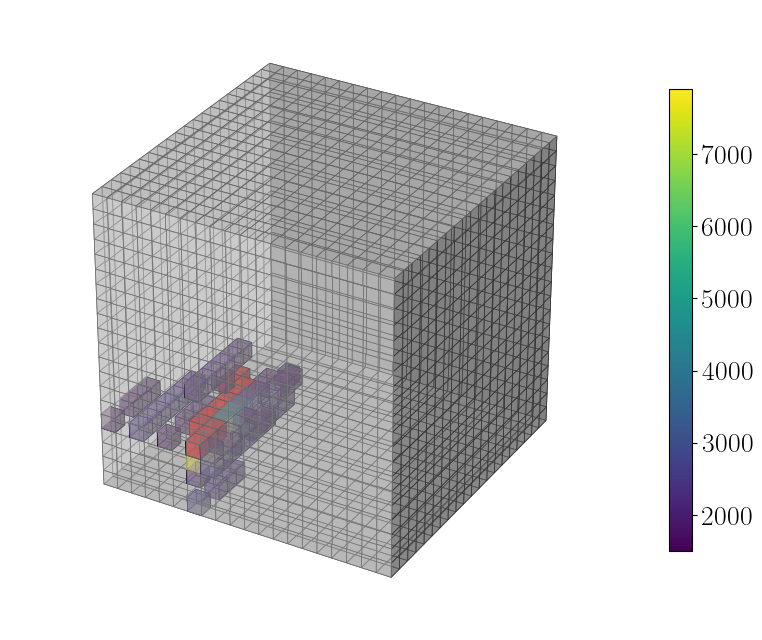

 33%|███▎      | 1/3 [00:02<00:05,  2.53s/it]

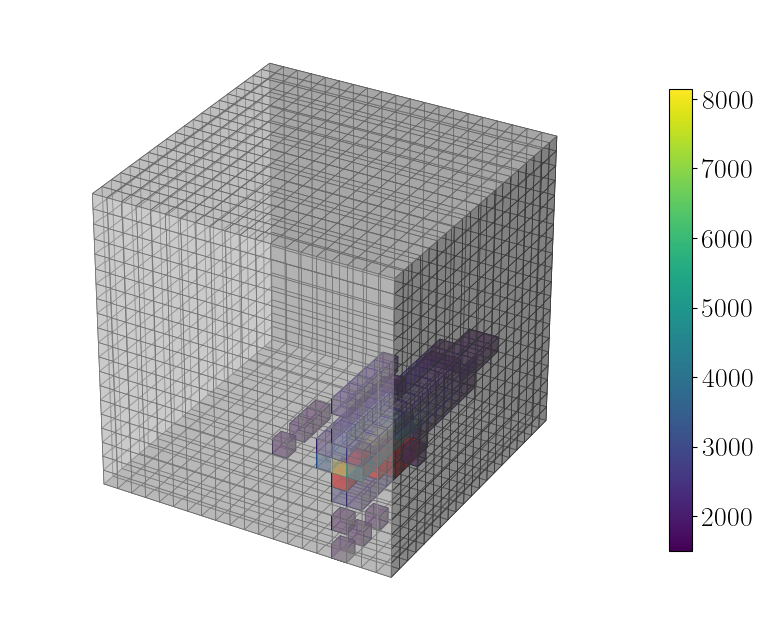

 67%|██████▋   | 2/3 [00:12<00:06,  6.75s/it]

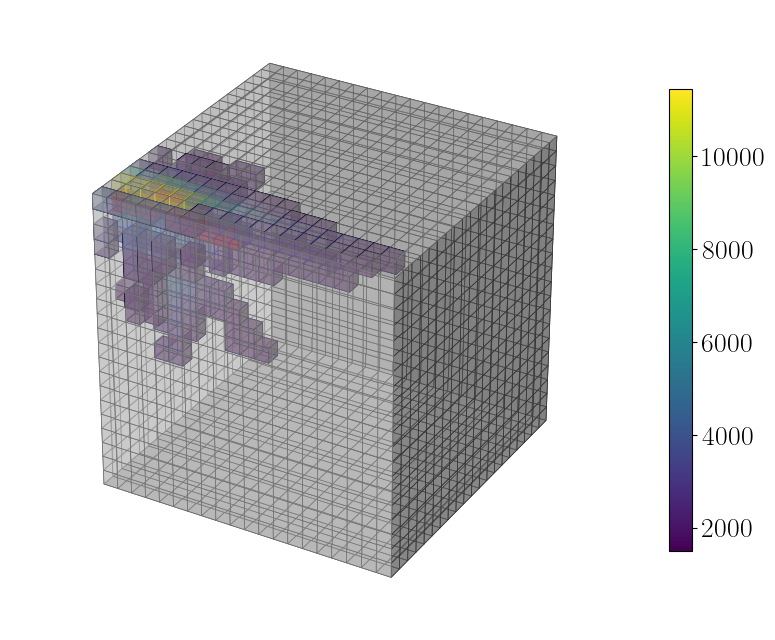

100%|██████████| 3/3 [00:14<00:00,  4.92s/it]


In [44]:
# %matplotlib qt
%matplotlib inline

indices = [46, 51, 52]
# indices = X_train_indices

plots = [False, False, True]
# plots = [True, True, True]
format = 'pdf'
resolution = 300

xEdges = np.linspace(-DETECTOR_SIZE_MM[0]/2, DETECTOR_SIZE_MM[0]/2, gridSize_input[0] + 1)
yEdges = np.linspace(-DETECTOR_SIZE_MM[1]/2, DETECTOR_SIZE_MM[1]/2, gridSize_input[1] + 1)
zEdges = np.linspace(-DETECTOR_SIZE_MM[2]/2, DETECTOR_SIZE_MM[2]/2, gridSize_input[2] + 1)

yEdges, xEdges, zEdges = np.meshgrid(xEdges, yEdges, zEdges)

alpha_empty  = 0.10
alpha_filled = 0.45
alpha_true   = 0.70

##################################################################################################
##################################################################################################
##################################################################################################

for ind in tqdm.tqdm(indices):
    vals = X[ind].sum(axis=-1)

    # set minHits to the 1 sigma value
    minHits = 1500
    maxHits = vals.max()

    # globalColorNorm = cm.colors.Normalize(vmin=0, vmax=np.max([X_train[ind].sum(axis=-1).max()]))
    globalColorNorm = cm.colors.Normalize(vmin=minHits, vmax=maxHits)
    # globalColorNorm = cm.colors.LogNorm(vmin=1, vmax=25)

    vals = np.where(vals < minHits, 0, vals)
    colors = cm.viridis(globalColorNorm(vals))

##################################################################################################
##################################################################################################
##################################################################################################

    if plots[0]:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')

        ax = plot_grid(
            ax,
            xEdges,
            yEdges,
            zEdges,
            recoGrid=vals,
            recoGridFaceColors=colors,
            recoGridEdgeColors=np.clip(colors*2-0.5, 0, 1),
            recoGridAlpha=alpha_filled,
            linewidth=0.5,
            cbar=True,
            colorNorm=globalColorNorm,
            cmap=cm.viridis
        )

        plt.savefig('../figures/voxelGrid_{}.{}'.format(ind, format), bbox_inches='tight', transparent=True, dpi=resolution)
        plt.show()

    ##################################################################################################
    ##################################################################################################
    ##################################################################################################

    if plots[1]:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')

        primary = pd.read_parquet(dfPaths_primary[X_train_indices[ind]])['position'].to_list()
        primary = np.array(primary)

        ax = plot_grid(
            ax,
            xEdges,
            yEdges,
            zEdges,
            trueGrid=Y[ind],
            truePoints=primary,
            trueGridFaceColors='r',
            trueGridEdgeColors='k',
            trueGridAlpha=alpha_true,
            linewidth=0.5,
            truePointsColor='b', 
            truePointsSize=10, 
            truePointsAlpha=1, 
            truePointsMarker='o'
        )

        plt.savefig('../figures/voxelGrid_truth_{}.{}'.format(ind, format), bbox_inches='tight', transparent=True, dpi=resolution)
        plt.show()

    ##################################################################################################
    ##################################################################################################
    ##################################################################################################
    ##################################################################################################

    if plots[2]:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')
        
        ax = plot_grid(
            ax,
            xEdges,
            yEdges,
            zEdges,
            recoGrid=vals,
            recoGridFaceColors=colors,
            recoGridEdgeColors=np.clip(colors*2-0.5, 0, 1),
            recoGridAlpha=alpha_filled,
            trueGrid=Y[ind],
            trueGridFaceColors='r',
            trueGridEdgeColors='k',
            trueGridAlpha=alpha_true,
            linewidth=0.5,
            cbar=True,
            colorNorm=globalColorNorm,
            cmap=cm.viridis
        )

        ax.set_axis_off()
        ax.set_aspect('equal')
        plt.savefig('../figures/voxelGrid_both_{}.{}'.format(ind, format), bbox_inches='tight', transparent=True, dpi=resolution)
        plt.show()

# Model

In [66]:
input_data = tf.keras.layers.Input(shape=X_size[1:])
# summed_data = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=-1))(input_data)

dropoutRate = 0.2

conv_1_1 = tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', padding='valid')(input_data)
conv_1_1_drop = tf.keras.layers.Dropout(dropoutRate)(conv_1_1)
maxPool_1_1 = tf.keras.layers.MaxPooling3D((2, 2, 2))(conv_1_1_drop)
conv_1_2 = tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', padding='valid')(maxPool_1_1)
conv_1_2_drop = tf.keras.layers.Dropout(dropoutRate)(conv_1_2)
maxPool_1_2 = tf.keras.layers.MaxPooling3D((2, 2, 2))(conv_1_2_drop)

mlp_conv = tf.keras.layers.Flatten()(maxPool_1_2)
mlp_1 = tf.keras.layers.Dense(256, activation='relu')(mlp_conv)
mpl_1_drop = tf.keras.layers.Dropout(dropoutRate)(mlp_1)
mlp_2 = tf.keras.layers.Dense(16**3, activation='relu')(mpl_1_drop)
mlp_2_drop = tf.keras.layers.Dropout(dropoutRate)(mlp_2)
mlp_res = tf.keras.layers.Reshape((16, 16, 16, 1))(mlp_2_drop)

deconv_1_1 = tf.keras.layers.Conv3DTranspose(64, (3, 3, 3), activation='relu', padding='valid')(mlp_res)
deconv_1_1_drop = tf.keras.layers.Dropout(dropoutRate)(deconv_1_1)
deconv_1_2 = tf.keras.layers.Conv3DTranspose(32, (3, 3, 3), activation='relu', padding='valid')(deconv_1_1_drop)
deconv_1_2_drop = tf.keras.layers.Dropout(dropoutRate)(deconv_1_2)

output = tf.keras.layers.Conv3D(1, (3, 3, 3), activation='relu', padding='same')(deconv_1_2_drop)

model = tf.keras.Model(inputs=input_data, outputs=output)

In [67]:
def sparse_loss(true, pred): 
    epsilon = 0.1 # 1 # 1e-7
    mask = tf.greater(true, epsilon)
    mask = tf.dtypes.cast(mask, tf.float32)

    loss_inMask = tf.square(tf.subtract(true, pred))
    loss_inMask = tf.multiply(loss_inMask, mask)
    loss_inMask /= tf.reduce_sum(mask)

    loss_outMask = tf.square(tf.subtract(true, pred))
    loss_outMask = tf.multiply(loss_outMask, 1-mask)
    loss_outMask /= tf.reduce_sum(1-mask)

    # return tf.reduce_mean(loss)
    return tf.reduce_sum(loss_inMask) + tf.reduce_sum(loss_outMask)

def distances_from_reco_to_true(true, pred, eps=8, optimize=False, minEntries=20, deltaEps=0.1):
    if type(true) == np.ndarray:
        true = tf.convert_to_tensor(true, dtype=tf.float32)
    if type(pred) == np.ndarray:
        pred = tf.convert_to_tensor(pred, dtype=tf.float32)

    pred = tf.cast(pred, tf.float32)
    true = tf.cast(true, tf.float32)
    deltaEps = tf.constant(deltaEps, dtype=tf.float32)
    eps = tf.constant(eps, dtype=tf.float32)

    if optimize:
        # while tf.where(tf.greater(pred, eps)).numpy().size < minEntries and eps > 0:
        # while tf.size(tf.where(tf.greater(pred, eps))) < minEntries and eps > 0.0:
        #     # print(tf.where(tf.greater(pred, eps)).numpy().size)
        #     eps -= deltaEps

        def condition(eps):
            return tf.size(tf.where(tf.greater(pred, eps))) < minEntries
        
        def body(eps):
            return [eps - deltaEps]
        
        eps = tf.while_loop(condition, body, [eps])

    mask = tf.cast(tf.greater(pred, eps), tf.float32)
    pred = pred * mask

    true = tf.reshape(true, (-1, 1))
    pred = tf.reshape(pred, (-1, 1))

    pred_ind = tf.where(tf.greater(pred, 0))
    true_ind = tf.where(tf.greater(true, 0))

    pred_ind = pred_ind[:, 0]
    true_ind = true_ind[:, 0]

    posTensor = tf.convert_to_tensor(grid_pos, dtype=tf.float32)

    pred_pos = tf.gather(posTensor, pred_ind)
    true_pos = tf.gather(posTensor, true_ind)

    pred_pos = tf.reshape(pred_pos, (-1, 3))
    true_pos = tf.reshape(true_pos, (-1, 3))

    pred_pos = tf.expand_dims(pred_pos, 1)
    true_pos = tf.expand_dims(true_pos, 0)

    distances = tf.norm(pred_pos - true_pos, axis=-1)
    minDistances = tf.reduce_min(distances, axis=1)

    return minDistances

def distances_from_true_to_reco(true, pred, eps=8, optimize=False, minEntries=20, deltaEps=0.1):
    return distances_from_reco_to_true(pred, true, eps=eps, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps)

def mean_distance_from_reco_to_true(true, pred, eps=8, optimize=False, minEntries=20, deltaEps=0.1):
    return tf.reduce_mean(distances_from_reco_to_true(true, pred, eps=eps, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps))

def mean_distance_from_true_to_reco(true, pred, eps=8, optimize=False, minEntries=20, deltaEps=0.1):
    return tf.reduce_mean(distances_from_true_to_reco(true, pred, eps=eps, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps))

def mean_and_distance_from_reco_to_true(true, pred, eps=8, optimize=False, minEntries=20, deltaEps=0.1):
    distances = distances_from_reco_to_true(true, pred, eps=eps, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps)
    return tf.reduce_mean(distances), distances

def mean_and_distance_from_true_to_reco(true, pred, eps=8, optimize=False, minEntries=20, deltaEps=0.1):
    distances = distances_from_true_to_reco(true, pred, eps=eps, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps)
    return tf.reduce_mean(distances), distances

def total_loss(true, pred, eps=15, optimize=True, minEntries=15, deltaEps=0.1, alpha=0.10, beta=0.10):
    return sparse_loss(true, pred) \
         + alpha * mean_distance_from_reco_to_true(true, pred, eps=eps, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps) \
         + beta  * mean_distance_from_true_to_reco(true, pred, eps=eps, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps)

In [68]:
custom_learning_rate = 0.01  # default = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=custom_learning_rate)
model.compile(optimizer, loss='mean_squared_error', #sparse_loss,
              metrics=['accuracy', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_logarithmic_error', 'cosine_similarity',
                       sparse_loss, total_loss,
                       mean_distance_from_reco_to_true, mean_distance_from_true_to_reco])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 20, 20, 20, 6)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_9 (Conv3D)               │ (None, 18, 18, 18, 32) │         5,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 18, 18, 18, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 9, 9, 9, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 7, 7, 7, 64)    │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 7, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 3, 3, 3, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1728)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       442,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 16, 16, 16, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_6              │ (None, 18, 18, 18, 64) │         1,792 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 18, 18, 18, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_7              │ (None, 20, 20, 20, 32) │        55,328 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 20, 20, 20, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 20, 20, 20, 1)  │           865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,613,857 (6.16 MB)

 Trainable params: 1,613,857 (6.16 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
useEarlyStopping = False
k = 1 # 5
nEpochs = 1 # 30
batchSize = 1
patience = 20

histories = []
# with tf.device('/GPU:0'):
with tf.device('/CPU:0'):
    if k != 1: 
        kFold = KFold(n_splits=k, shuffle=True)
        for i, (train_index, val_index) in tqdm.tqdm(enumerate(kFold.split(X_train))):
            X_train_k, X_val_k = X_train[train_index], X_train[val_index]
            Y_train_k, Y_val_k = Y_train[train_index], Y_train[val_index]

            if useEarlyStopping:
                early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
                histories.append(model.fit(X_train_k, Y_train_k, epochs=nEpochs, batch_size=batchSize, validation_data=(X_val_k, Y_val_k), callbacks=[early_stopping_callback]))
            else:
                histories.append(model.fit(X_train_k, Y_train_k, epochs=nEpochs, batch_size=batchSize, validation_data=(X_val_k, Y_val_k)))
    else:
        if useEarlyStopping:
            early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
            histories.append(model.fit(X_train, Y_train, epochs=nEpochs, batch_size=batchSize, validation_split=0.2, callbacks=[early_stopping_callback]))
        else:
            histories.append(model.fit(X_train, Y_train, epochs=nEpochs, batch_size=batchSize, validation_split=0.2))

print('Metrics: ', histories[0].history.keys())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.9980 - cosine_similarity: 0.0000e+00 - loss: 0.0020 - mean_absolute_error: 0.0020 - mean_absolute_percentage_error: 0.2000 - mean_distance_from_reco_to_true: nan - mean_distance_from_true_to_reco: nan - mean_squared_error: 0.0020 - mean_squared_logarithmic_error: 9.6091e-04 - sparse_loss: 20.0000 - total_loss: nan
Metrics:  dict_keys(['accuracy', 'cosine_similarity', 'loss', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_distance_from_reco_to_true', 'mean_distance_from_true_to_reco', 'mean_squared_error', 'mean_squared_logarithmic_error', 'sparse_loss', 'total_loss'])


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_23816/3363097568.py:64: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax1.set_xlim(0, len(total_loss)-1)


ValueError: Axis limits cannot be NaN or Inf

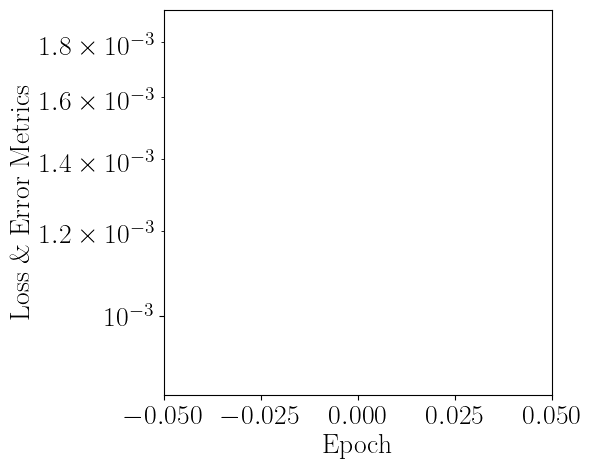

In [ ]:
%matplotlib inline

fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
# ax2 = ax1.twinx()

total_loss                                = np.concatenate([history.history['loss'                               ] for history in histories])
total_val_loss                            = np.concatenate([history.history['val_loss'                           ] for history in histories])
total_mse                                 = np.concatenate([history.history['mean_squared_error'                 ] for history in histories])
total_val_mse                             = np.concatenate([history.history['val_mean_squared_error'             ] for history in histories])
total_mae                                 = np.concatenate([history.history['mean_absolute_error'                ] for history in histories])
total_val_mae                             = np.concatenate([history.history['val_mean_absolute_error'            ] for history in histories])
total_msle                                = np.concatenate([history.history['mean_squared_logarithmic_error'     ] for history in histories])
total_val_msle                            = np.concatenate([history.history['val_mean_squared_logarithmic_error' ] for history in histories])
total_cosine                              = np.concatenate([history.history['cosine_similarity'                  ] for history in histories])
total_val_cosine                          = np.concatenate([history.history['val_cosine_similarity'              ] for history in histories])
total_sparse_loss                         = np.concatenate([history.history['sparse_loss'                        ] for history in histories])
total_val_sparse_loss                     = np.concatenate([history.history['val_sparse_loss'                    ] for history in histories])
total_total_loss                          = np.concatenate([history.history['total_loss'                         ] for history in histories])
total_val_total_loss                      = np.concatenate([history.history['val_total_loss'                     ] for history in histories])
total_mean_distance_from_reco_to_true     = np.concatenate([history.history['mean_distance_from_reco_to_true'    ] for history in histories])
total_val_mean_distance_from_reco_to_true = np.concatenate([history.history['val_mean_distance_from_reco_to_true'] for history in histories])
total_mean_distance_from_true_to_reco     = np.concatenate([history.history['mean_distance_from_true_to_reco'    ] for history in histories])
total_val_mean_distance_from_true_to_reco = np.concatenate([history.history['val_mean_distance_from_true_to_reco'] for history in histories])
nEpochs = [len(history.history['loss']) for history in histories]

maxY = max(np.max(total_loss), np.max(total_val_loss))

ax1.plot(total_sparse_loss, label='Training SL', color=twilight[5,:])
ax1.plot(total_val_sparse_loss, label='Validation SL', color=twilight[40-5,:])

ax1.plot(total_mse, label='Training MSE', color=twilight[7,:], linestyle='--')
ax1.plot(total_val_mse, label='Validation MSE', color=twilight[40-7,:] , linestyle='--')

ax1.plot(total_mae, label='Training MAE', color=twilight[9,:], linestyle='-.')
ax1.plot(total_val_mae, label='Validation MAE', color=twilight[40-9,:], linestyle='-.')

ax1.plot(total_msle, label='Training MSLE', color=twilight[11,:], linestyle=':')
ax1.plot(total_val_msle, label='Validation MSLE', color=twilight[40-11,:], linestyle=':')

# ax1.plot(total_cosine, label='Training Cosine', color=twilight[13,:], linestyle='-.')
# ax1.plot(total_val_cosine, label='Validation Cosine', color=twilight[40-13,:], linestyle='-.')

# ax1.plot(total_mean_distance_from_reco_to_true, label=r'Training Reco $\to$ True', color=twilight[15,:], linestyle='--')
# ax1.plot(total_val_mean_distance_from_reco_to_true, label=r'Validation Reco $\to$ True', color=twilight[40-15,:], linestyle='--')

# ax1.plot(total_mean_distance_from_true_to_reco, label=r'Training True $\to$ Reco', color=twilight[17,:], linestyle='-.')
# ax1.plot(total_val_mean_distance_from_true_to_reco, label=r'Validation True $\to$ Reco', color=twilight[40-17,:], linestyle='-.')

ax1.vlines(np.cumsum(nEpochs)-1, 0, maxY, color='k', linestyle=':', alpha=0.5)

# ax2.plot(history.history['accuracy'], label='Training Accuracy', color=twilight[9,:], linestyle=':')
# ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color=twilight[40-9,:], linestyle=':')
# ax1.plot([], [], label='Training Accuracy', color=twilight[9,:], linestyle=':')
# ax1.plot([], [], label='Validation Accuracy', color=twilight[40-9,:], linestyle=':')

ax1.set_xlabel('Epoch')

ax1.set_ylabel(r'Loss \& Error Metrics')
# ax2.set_ylabel('Accuracy Metrics')

ax1.set_yscale('log')
# ax2.set_yscale('log')

ax1.set_xlim(0, len(total_loss)-1)
# ax2.set_xlim(0, len(history.history['loss'])-1)
ax1.set_ylim(0, maxY)
# ax2.set_ylim(ymin=0, ymax=1)

ax1.grid()
# ax2.grid()

# ax1.set_title('Training history')
ax1.legend(bbox_to_anchor=(1.25, 1), loc='upper left')
plt.savefig('../figures/training.pdf', bbox_inches='tight')
plt.show()

In [ ]:
saveModel   = False
loadModel   = False
saveHistory = False
loadHistory = False

# fileName = 'models/model_{}_{}.h5'.format(plotRecoName, {True:'withErrors', False:'noErrors'}[makeErrors])
fileName = 'models/model_200multievent_20x20x20_5kFold_30epochs_primaryLabels_updatedLabels.h5'
if saveModel:
    model.save(fileName)
    print('Saved model to', fileName)
if loadModel:
    meanDistanceToTrueFromReco = mean_distance_from_reco_to_true
    meanDistanceToRecoFromTrue = mean_distance_from_true_to_reco
    # model = tf.keras.models.load_model(fileName, custom_objects={'sparse_loss': sparse_loss, 
    #                                                              'mean_distance_from_reco_to_true': mean_distance_from_reco_to_true,
    #                                                              'mean_distance_from_true_to_reco': mean_distance_from_true_to_reco})
    model = tf.keras.models.load_model(fileName, custom_objects={'sparse_loss': sparse_loss,
                                                                 'meanDistanceToTrueFromReco': meanDistanceToTrueFromReco,
                                                                 'meanDistanceToRecoFromTrue': meanDistanceToRecoFromTrue})
    print('Loaded model from', fileName)
if saveHistory:
    historiesSave = []
    for history in histories:
        historiesSave.append({key: history.history[key] for key in history.history.keys()})
    with open(fileName.split('.')[0]+'_history.pkl', 'wb') as file_pi:
        pkl.dump(historiesSave, file_pi)
if loadHistory:
    with open(fileName.split('.')[0]+'_history.pkl', 'rb') as file_pi:
        historiesLoad = pkl.load(file_pi)

In [ ]:
nBins = 50
xmax = 200
# xmax = None
lw = 2
colors = [twilight[5,:], twilight[40-5,:], twilight[12,:], twilight[40-12,:]]
density = True
plots = [True, False]
epsInit = 15
optimize = True
minEntries = 15
deltaEps = 0.1

mean_distance_from_true_to_reco_test = []
mean_distance_from_reco_to_true_test = []
mean_distance_from_true_to_reco_train = []
mean_distance_from_reco_to_true_train = []
distances_from_true_to_reco_test = []
distances_from_reco_to_true_test = []
distances_from_true_to_reco_train = []
distances_from_reco_to_true_train = []

for i in tqdm.tqdm(range(len(X_test))):
    mean, distances = mean_and_distance_from_true_to_reco(Y_test[i], model.predict(X_test[i:i+1], verbose=0), eps=epsInit, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps)
    mean_distance_from_true_to_reco_test.append(mean)
    distances_from_true_to_reco_test.append(distances.numpy())

    mean, distances = mean_and_distance_from_reco_to_true(Y_test[i], model.predict(X_test[i:i+1], verbose=0)[0], eps=epsInit, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps)
    mean_distance_from_reco_to_true_test.append(mean)
    distances_from_reco_to_true_test.append(distances.numpy())
for i in tqdm.tqdm(range(len(X_train))):
    mean, distances = mean_and_distance_from_true_to_reco(Y_train[i], model.predict(X_train[i:i+1], verbose=0)[0], eps=epsInit, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps)
    mean_distance_from_true_to_reco_train.append(mean)
    distances_from_true_to_reco_train.append(distances.numpy())

    mean, distances = mean_and_distance_from_reco_to_true(Y_train[i], model.predict(X_train[i:i+1], verbose=0)[0], eps=epsInit, optimize=optimize, minEntries=minEntries, deltaEps=deltaEps)
    mean_distance_from_reco_to_true_train.append(mean)
    distances_from_reco_to_true_train.append(distances.numpy())

print(distances_from_reco_to_true_test[0].shape)
print(distances_from_reco_to_true_test[0])
print(distances_from_true_to_reco_test[0].shape)
print(distances_from_true_to_reco_test[0])

mean_distance_from_true_to_reco_test = np.array(mean_distance_from_true_to_reco_test)
mean_distance_from_reco_to_true_test = np.array(mean_distance_from_reco_to_true_test)
mean_distance_from_true_to_reco_train = np.array(mean_distance_from_true_to_reco_train)
mean_distance_from_reco_to_true_train = np.array(mean_distance_from_reco_to_true_train)

mean_distance_from_true_to_reco_test = mean_distance_from_true_to_reco_test[~np.isnan(mean_distance_from_true_to_reco_test)]
mean_distance_from_reco_to_true_test = mean_distance_from_reco_to_true_test[~np.isnan(mean_distance_from_reco_to_true_test)]
mean_distance_from_true_to_reco_train = mean_distance_from_true_to_reco_train[~np.isnan(mean_distance_from_true_to_reco_train)]
mean_distance_from_reco_to_true_train = mean_distance_from_reco_to_true_train[~np.isnan(mean_distance_from_reco_to_true_train)]

for i in range(len(distances_from_reco_to_true_test)):
    distances_from_reco_to_true_test[i] = distances_from_reco_to_true_test[i][~np.isnan(distances_from_reco_to_true_test[i])]
for i in range(len(distances_from_true_to_reco_test)):
    distances_from_true_to_reco_test[i] = distances_from_true_to_reco_test[i][~np.isnan(distances_from_true_to_reco_test[i])]
for i in range(len(distances_from_reco_to_true_train)):
    distances_from_reco_to_true_train[i] = distances_from_reco_to_true_train[i][~np.isnan(distances_from_reco_to_true_train[i])]
for i in range(len(distances_from_true_to_reco_train)):
    distances_from_true_to_reco_train[i] = distances_from_true_to_reco_train[i][~np.isnan(distances_from_true_to_reco_train[i])]

##################################################################################################################
##################################################################################################################
##################################################################################################################

if plots[0] and plots[1]:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
elif plots[0] or plots[1]:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax = [ax, ax]

if plots[0]:
    if xmax is None:
        xmax = np.max([np.max(mean_distance_from_reco_to_true_test), np.max(mean_distance_from_true_to_reco_test), np.max(mean_distance_from_true_to_reco_train), np.max(mean_distance_from_true_to_reco_train)])


    bins_TR_train, edges_TR_train, _ = ax[0].hist(mean_distance_from_true_to_reco_train, bins=nBins, range=(0, xmax), histtype='step', color=colors[2], linewidth=lw, density=density)
    bins_RT_train, edges_RT_train, _ = ax[0].hist(mean_distance_from_reco_to_true_train, bins=nBins, range=(0, xmax), histtype='step', color=colors[3], linewidth=lw, density=density)
    bins_TR_test, edges_TR_test, _ = ax[0].hist(mean_distance_from_true_to_reco_test, bins=nBins, range=(0, xmax), histtype='step', color=colors[0], linewidth=lw, density=density)
    bins_RT_test, edges_RT_test, _ = ax[0].hist(mean_distance_from_reco_to_true_test, bins=nBins, range=(0, xmax), histtype='step', color=colors[1], linewidth=lw, density=density)

    bins_TR_train_step = np.insert(bins_TR_train.repeat(2), [0, len(bins_TR_train)*2], 0)
    bins_RT_train_step = np.insert(bins_RT_train.repeat(2), [0, len(bins_RT_train)*2], 0)
    bins_TR_test_step = np.insert(bins_TR_test.repeat(2), [0, len(bins_TR_test)*2], 0)
    bins_RT_test_step = np.insert(bins_RT_test.repeat(2), [0, len(bins_RT_test)*2], 0)

    edges_TR_train_step = np.array(edges_TR_train).repeat(2)
    edges_RT_train_step = np.array(edges_RT_train).repeat(2)
    edges_TR_test_step = np.array(edges_TR_test).repeat(2)
    edges_RT_test_step = np.array(edges_RT_test).repeat(2)

    path_TR_train = Path(np.array([edges_TR_train_step, bins_TR_train_step]).T)
    path_RT_train = Path(np.array([edges_RT_train_step, bins_RT_train_step]).T)
    path_TR_test = Path(np.array([edges_TR_test_step, bins_TR_test_step]).T)
    path_RT_test = Path(np.array([edges_RT_test_step, bins_RT_test_step]).T)

    patch_TR_train = PathPatch(path_TR_train, facecolor='None', edgecolor=colors[2], alpha=1, hatch=r'\\', label=r'Train True $\to$ Reco')
    patch_RT_train = PathPatch(path_RT_train, facecolor='None', edgecolor=colors[3], alpha=1, hatch=r'\\', label=r'Train Reco $\to$ True')
    patch_TR_test = PathPatch(path_TR_test, facecolor='None', edgecolor=colors[0], alpha=1, hatch='//', label=r'Test True $\to$ Reco')
    patch_RT_test = PathPatch(path_RT_test, facecolor='None', edgecolor=colors[1], alpha=1, hatch='//', label=r'Test Reco $\to$ True')

    ax[0].add_patch(patch_TR_train)
    ax[0].add_patch(patch_RT_train)
    ax[0].add_patch(patch_TR_test)
    ax[0].add_patch(patch_RT_test)

    ax[0].set_yscale('log')
    ax[0].set_xlabel('Mean Distance [mm]')
    ax[0].set_ylabel('Density')
    ax[0].set_xlim(0, xmax)
    ax[0].legend()
    ax[0].grid()

##################################################################################################################
##################################################################################################################
##################################################################################################################

if plots[1]:
    if xmax is None:
        xmax = np.max([np.max(np.concatenate(distances_from_reco_to_true_train)), np.max(np.concatenate(distances_from_true_to_reco_train)), np.max(np.concatenate(distances_from_reco_to_true_test)), np.max(np.concatenate(distances_from_true_to_reco_test))])

    bins_TR_train, edges_TR_train, _ = ax[1].hist(np.concatenate(distances_from_true_to_reco_train), bins=nBins, range=(0, xmax), histtype='step', color=colors[2], linewidth=lw, density=density)
    bins_RT_train, edges_RT_train, _ = ax[1].hist(np.concatenate(distances_from_reco_to_true_train), bins=nBins, range=(0, xmax), histtype='step', color=colors[3], linewidth=lw, density=density)
    bins_TR_test, edges_TR_test, _ = ax[1].hist(np.concatenate(distances_from_true_to_reco_test), bins=nBins, range=(0, xmax), histtype='step', color=colors[0], linewidth=lw, density=density)
    bins_RT_test, edges_RT_test, _ = ax[1].hist(np.concatenate(distances_from_reco_to_true_test), bins=nBins, range=(0, xmax), histtype='step', color=colors[1], linewidth=lw, density=density)

    bins_TR_train_step = np.insert(bins_TR_train.repeat(2), [0, len(bins_TR_train)*2], 0)
    bins_RT_train_step = np.insert(bins_RT_train.repeat(2), [0, len(bins_RT_train)*2], 0)
    bins_TR_test_step = np.insert(bins_TR_test.repeat(2), [0, len(bins_TR_test)*2], 0)
    bins_RT_test_step = np.insert(bins_RT_test.repeat(2), [0, len(bins_RT_test)*2], 0)

    edges_TR_train_step = np.array(edges_TR_train).repeat(2)
    edges_RT_train_step = np.array(edges_RT_train).repeat(2)
    edges_TR_test_step = np.array(edges_TR_test).repeat(2)
    edges_RT_test_step = np.array(edges_RT_test).repeat(2)

    path_TR_train = Path(np.array([edges_TR_train_step, bins_TR_train_step]).T)
    path_RT_train = Path(np.array([edges_RT_train_step, bins_RT_train_step]).T)
    path_TR_test = Path(np.array([edges_TR_test_step, bins_TR_test_step]).T)
    path_RT_test = Path(np.array([edges_RT_test_step, bins_RT_test_step]).T)

    patch_TR_train = PathPatch(path_TR_train, facecolor='None', edgecolor=colors[2], alpha=1, hatch=r'\\', label=r'Train: True $\to$ Reco')
    patch_RT_train = PathPatch(path_RT_train, facecolor='None', edgecolor=colors[3], alpha=1, hatch=r'\\', label=r'Train: Reco $\to$ True')
    patch_TR_test = PathPatch(path_TR_test, facecolor='None', edgecolor=colors[0], alpha=1, hatch='//', label=r'Test: True $\to$ Reco')
    patch_RT_test = PathPatch(path_RT_test, facecolor='None', edgecolor=colors[1], alpha=1, hatch='//', label=r'Test: Reco $\to$ True')

    ax[1].add_patch(patch_TR_train)
    ax[1].add_patch(patch_RT_train)
    ax[1].add_patch(patch_TR_test)
    ax[1].add_patch(patch_RT_test)

    ax[1].set_yscale('log')
    ax[1].set_xlabel('Distance [mm]')
    ax[1].set_ylabel('Density')
    ax[1].set_xlim(0, xmax)
    ax[1].legend()
    ax[1].grid()

plt.savefig('../figures/meanDistances.pdf', bbox_inches='tight')
plt.show()

  5%|▍         | 52/1118 [00:28<09:52,  1.80it/s]


KeyboardInterrupt: 

  0%|          | 0/1137 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
np.min(predGrid) 0.0
np.max(predGrid) 0.0


  0%|          | 1/1137 [00:05<1:40:06,  5.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
np.min(predGrid) 0.0
np.max(predGrid) 0.0


  0%|          | 2/1137 [00:06<52:20,  2.77s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
np.min(predGrid) 0.0
np.max(predGrid) 0.0


  0%|          | 3/1137 [00:07<36:25,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
np.min(predGrid) 0.0
np.max(predGrid) 0.0


  0%|          | 4/1137 [00:08<29:07,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
np.min(predGrid) 0.0
np.max(predGrid) 0.0


  0%|          | 5/1137 [00:09<24:58,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
np.min(predGrid) 0.0
np.max(predGrid) 0.0


  1%|          | 6/1137 [00:10<22:44,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
np.min(predGrid) 0.0
np.max(predGrid) 0.0


  1%|          | 7/1137 [00:14<39:30,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
np.min(predGrid) 0.0
np.max(predGrid) 0.0


  1%|          | 8/1137 [00:15<32:53,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
np.min(predGrid) 0.0
np.max(predGrid) 0.0


  1%|          | 9/1137 [00:15<28:12,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
np.min(predGrid) 0.0
np.max(predGrid) 0.0


  1%|          | 10/1137 [00:17<25:56,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
np.min(predGrid) 0.0
np.max(predGrid) 0.0


  1%|          | 11/1137 [00:18<23:35,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
np.min(predGrid) 0.0
np.max(predGrid) 0.0


  1%|          | 12/1137 [00:19<22:27,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
np.min(predGrid) 0.0
np.max(predGrid) 0.0


  1%|          | 13/1137 [00:20<21:05,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
np.min(predGrid) 0.0
np.max(predGrid) 0.0


  1%|          | 14/1137 [00:21<20:04,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
np.min(predGrid) 0.0
np.max(predGrid) 0.0


  1%|▏         | 15/1137 [00:24<34:38,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
np.min(predGrid) 0.0
np.max(predGrid) 0.0


  1%|▏         | 16/1137 [00:25<29:34,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
np.min(predGrid) 0.0
np.max(predGrid) 0.0


  1%|▏         | 17/1137 [00:26<25:54,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
np.min(predGrid) 0.0
np.max(predGrid) 0.0


  2%|▏         | 18/1137 [00:27<23:23,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
np.min(predGrid) 0.0
np.max(predGrid) 0.0


  2%|▏         | 19/1137 [00:28<21:38,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
np.min(predGrid) 0.0
np.max(predGrid) 0.0


  2%|▏         | 20/1137 [00:29<20:18,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  2%|▏         | 20/1137 [00:29<27:24,  1.47s/it]

np.min(predGrid) 0.0
np.max(predGrid) 0.19576044


IndexError: index 5 is out of bounds for axis 0 with size 5

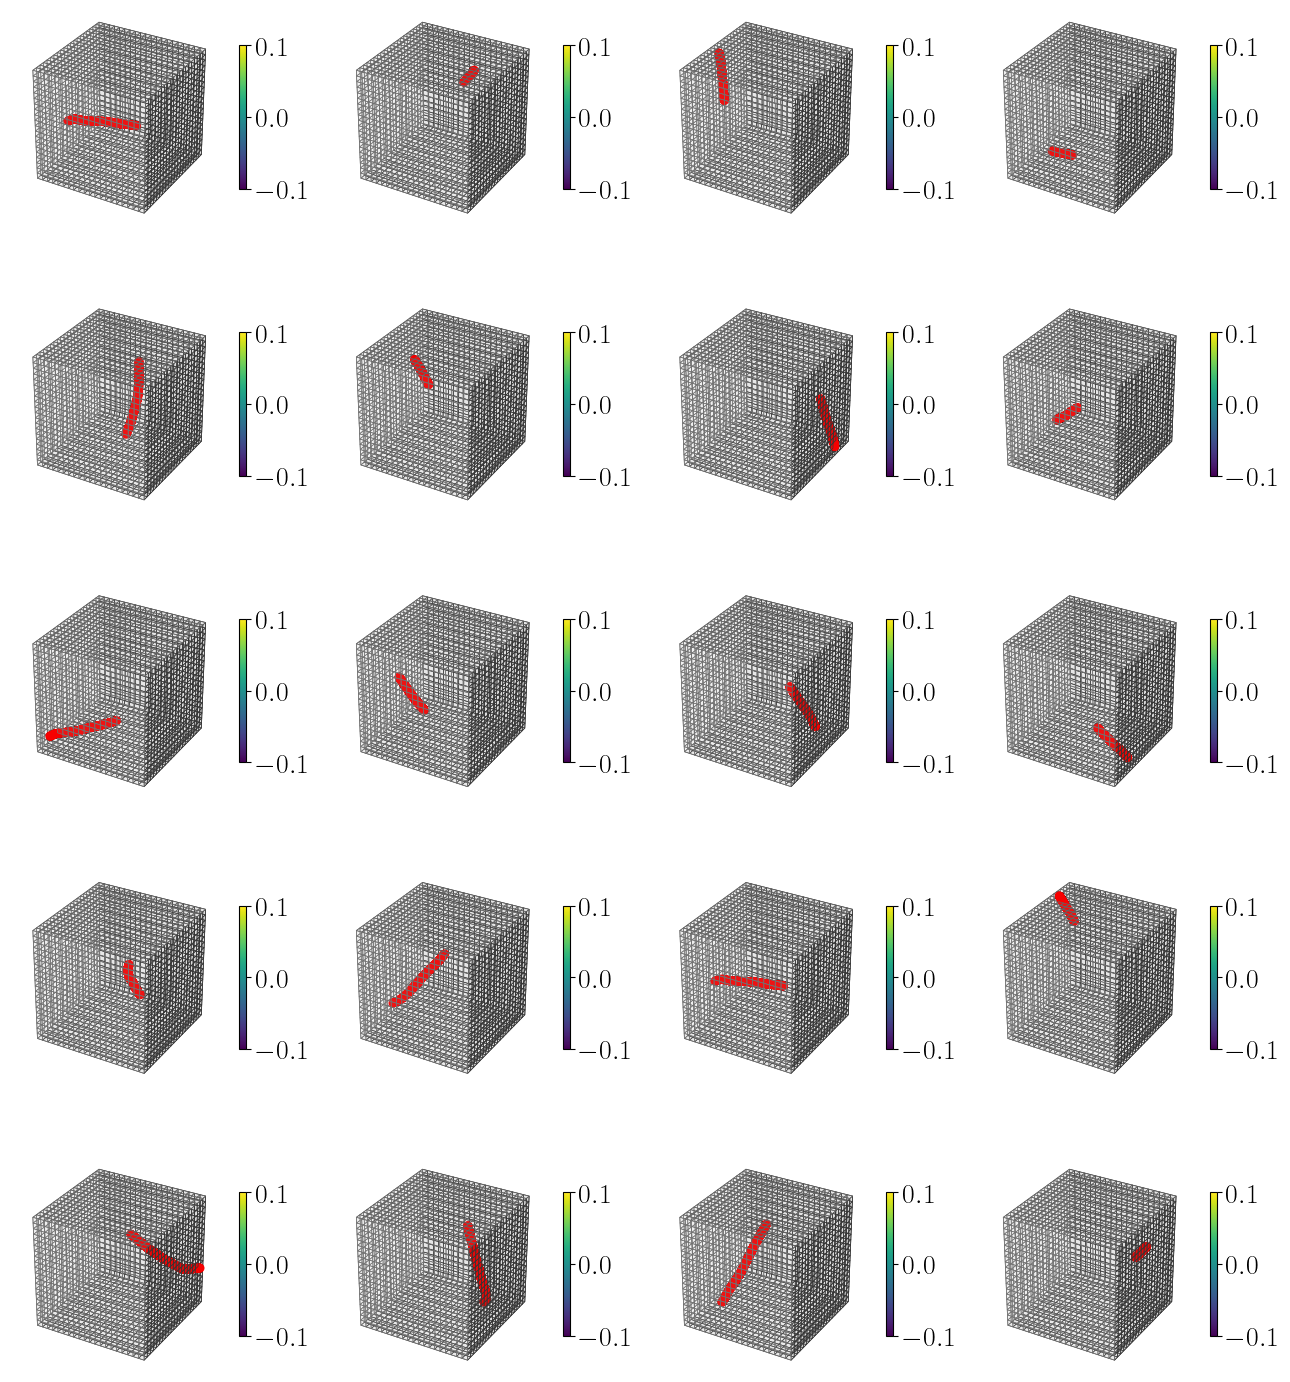

In [74]:
# %matplotlib qt
%matplotlib inline

inds = range(len(X_test))
# inds = [2]
epsInit = 12 # 0.2
minNshown = 15

nCols = 4
nRows = 5
fig, axs = plt.subplots(nRows, nCols, figsize=(16, 18), subplot_kw={'projection': '3d'})

scale = 1000

# globalColorNorm = cm.colors.Normalize(vmin=5, vmax=12)

xPlot, yPlot, xInd = X_test, Y_test, X_test_indices
# xPlot, yPlot, xInd = X_train, Y_train, X_train_indices

xEdges = np.linspace(-DETECTOR_SIZE_MM[0]/2/scale, DETECTOR_SIZE_MM[0]/2/scale, gridSize_input[0] + 1)
yEdges = np.linspace(-DETECTOR_SIZE_MM[1]/2/scale, DETECTOR_SIZE_MM[1]/2/scale, gridSize_input[1] + 1)
zEdges = np.linspace(-DETECTOR_SIZE_MM[2]/2/scale, DETECTOR_SIZE_MM[2]/2/scale, gridSize_input[2] + 1)
yEdges, xEdges, zEdges = np.meshgrid(xEdges, yEdges, zEdges)

for ind in tqdm.tqdm(inds):
    trueGrid = yPlot[ind]
    predGrid = model.predict(xPlot[ind].reshape(1, 
                                            gridSize_input[0], 
                                            gridSize_input[1], 
                                            gridSize_input[2], 
                                            6)).reshape(gridSize_output)
    print('np.min(predGrid)', np.min(predGrid))
    print('np.max(predGrid)', np.max(predGrid))
    globalColorNorm = cm.colors.Normalize(vmin=np.min(predGrid), vmax=np.max(predGrid))

    # eps = epsInit
    # while True:
    #     nonZeroInd = np.where(predGrid.flatten()>eps)
    #     if len(nonZeroInd[0]) >= minNshown:
    #         break
    #     elif eps < 0:
    #         break
    #     eps -= 0.1

    primaryTrue = np.array(pd.read_parquet(dfPaths_primary[xInd[ind]])['position'].to_list())
    colors = cm.viridis(globalColorNorm(predGrid))

    axs[ind//nCols, ind%nCols] = plot_grid(
        axs[ind//nCols, ind%nCols],
        xEdges,
        yEdges,
        zEdges,
        recoGrid=predGrid,
        recoGridFaceColors=colors,
        recoGridEdgeColors=np.clip(colors*2-0.5, 0, 1),
        recoGridAlpha=0.8,
        # trueGrid=trueGrid,
        # trueGridFaceColors='r',
        # trueGridEdgeColors='k',
        # trueGridAlpha=0.1,
        nullGridAlpha=0.1,
        linewidth=0.5,
        truePoints=primaryTrue/scale,
        truePointsColor='r',
        truePointsSize=30,
        truePointsAlpha=0.1,
        # cbar=False,
        cbar=True,
        colorNorm=globalColorNorm,
        cmap=cm.viridis
    )

    axs[ind//nCols, ind%nCols].set_xlim(-DETECTOR_SIZE_MM[0]/2/scale, DETECTOR_SIZE_MM[0]/2/scale)
    axs[ind//nCols, ind%nCols].set_ylim(-DETECTOR_SIZE_MM[1]/2/scale, DETECTOR_SIZE_MM[1]/2/scale)
    axs[ind//nCols, ind%nCols].set_zlim(-DETECTOR_SIZE_MM[2]/2/scale, DETECTOR_SIZE_MM[2]/2/scale)

    axs[ind//nCols, ind%nCols].set_xlabel(r'$x$ [m]', labelpad=7)
    axs[ind//nCols, ind%nCols].set_ylabel(r'$y$ [m]')
    axs[ind//nCols, ind%nCols].set_zlabel(r'$z$ [m]', labelpad=0)

axNew = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axNew.set_visible(False)
cbar = plt.colorbar(cm.ScalarMappable(norm=globalColorNorm, cmap=cm.viridis), ax=axNew, orientation='horizontal', label='Predicted Weight', alpha=0.2, pad=0.1, aspect=40, shrink=0.8, extend='both')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.set_position([0.11, 0.1, 0.8, 0.9])

axExtend = fig.add_axes([1.1, 0.1, 0.1, 0.8])
axExtend.set_visible(True)

fig.tight_layout()
plt.savefig('../figures/allTestEvents.pdf', bbox_inches='tight')
plt.show()